In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

%matplotlib inline

### Подготовка данных

#### Чистим данные

In [8]:
df = pd.read_csv('for_clustering.csv')

In [9]:
print(df.shape)
df.head()

(27508, 46)


,Unnamed: 0,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,...,0.081007,1,1,60,12,963.01,1,1,2,2
1,1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,...,0.036766,1,0,91,15,1534.69,1,1,2,2
2,2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,...,0.112974,1,1,13,2,1514.48,1,1,3,3
3,3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,...,0.027406,1,0,68,35,1872.24,1,1,2,2
4,4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,...,0.042788,1,1,22,3,557.97,1,1,1,1


Избавляемся от строк с отсутствующими данными.

Удаляем дублирующиеся строки.

In [10]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
print(df.shape)

(27267, 47)


Ищем колонки, которые нельзя привести к числовому виду

In [11]:
no_num_cols = []
for column in df.columns:
    isnum = pd.to_numeric(df[column][~df[column].isna()], errors='coerce').notnull().all()
    if not isnum:
        no_num_cols.append(column)
        
df[no_num_cols].head()

,Gender,Age_group
0,F,35-45
1,F,25-35
2,F,25-35
3,F,45-55
4,F,25-35


Колонку 'Gender' и 'Age_group' преобразуем в числа.

In [13]:
df.drop(columns=['Id_client', 'index'], inplace=True)

gender = {'M': 0,'F': 1}
df['Gender'] = [gender[item] for item in df['Gender']]

age_group = {'0-25':0, '25-35':1, '35-45':2, '45-55':3, '55-65':4, '65+':5}
df['Age_group'] = [age_group[item] for item in df['Age_group']]

Наконец, все колонки превращаем в тип float.

In [17]:
for col in df.columns:
    df[col] = df[col].astype('float')

На этом этапе, перед тем как мы поменяли что-то в данных, делаем копию

In [18]:
df_raw = df.copy()

#### Нормализуем

Для начала посмотрим на распределения величин в каждой из колонок:

<ipython-input-27-698f47c48f7e>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=ax, layout=(rows,cols), bins=200)


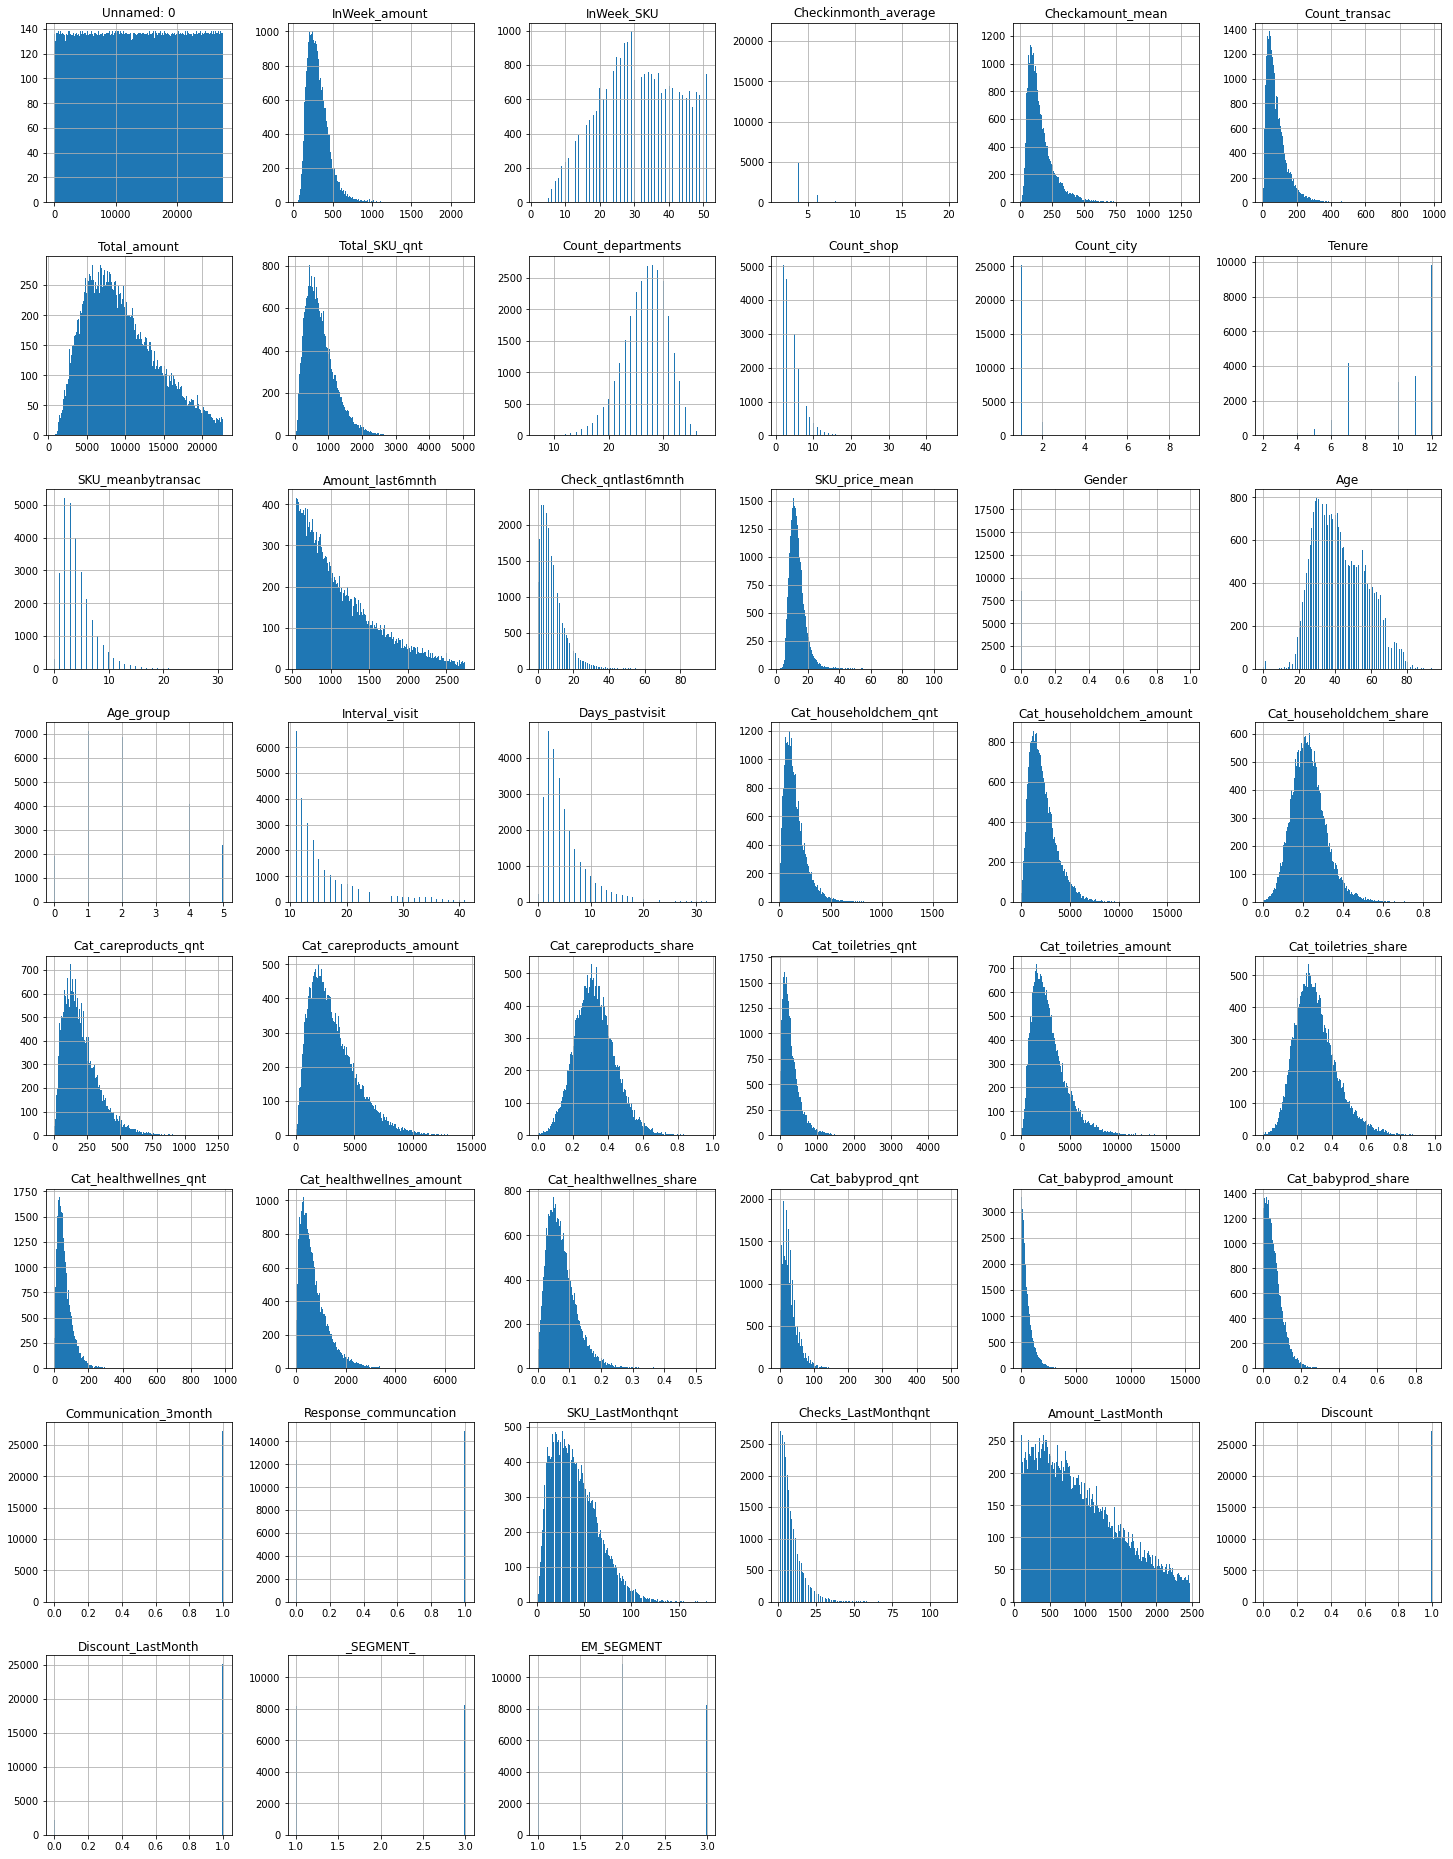

In [27]:
cols = 6
rows = df.shape[1] // cols + 1

figsize_x = 25
figsize_y = figsize_x/cols*rows

fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
df.hist(ax=ax, layout=(rows,cols), bins=200)

plt.show()

Распределения величин в большинстве колонок - колоколообразное.

Корректируем асимметрию распределения, если она есть.

Нормировкой и смещением среднего приведем распределения к виду стандартного нормального распределения.

Нормировка необходима для того, чтобы при дальнейшем анализе не сказывался разный масштаб параметров.

In [28]:
skewed = df.columns[abs(df.skew())>1]
for col in skewed:
    if abs(df[col].skew()) > abs(np.log1p(df[col]).skew()):
        df[col] = np.log1p(df[col])
        
del skewed

In [29]:
for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()

#### Взаимная корреляция столбцов:

Бывает полезно посмотреть на корреляционную матрицу

<AxesSubplot:>

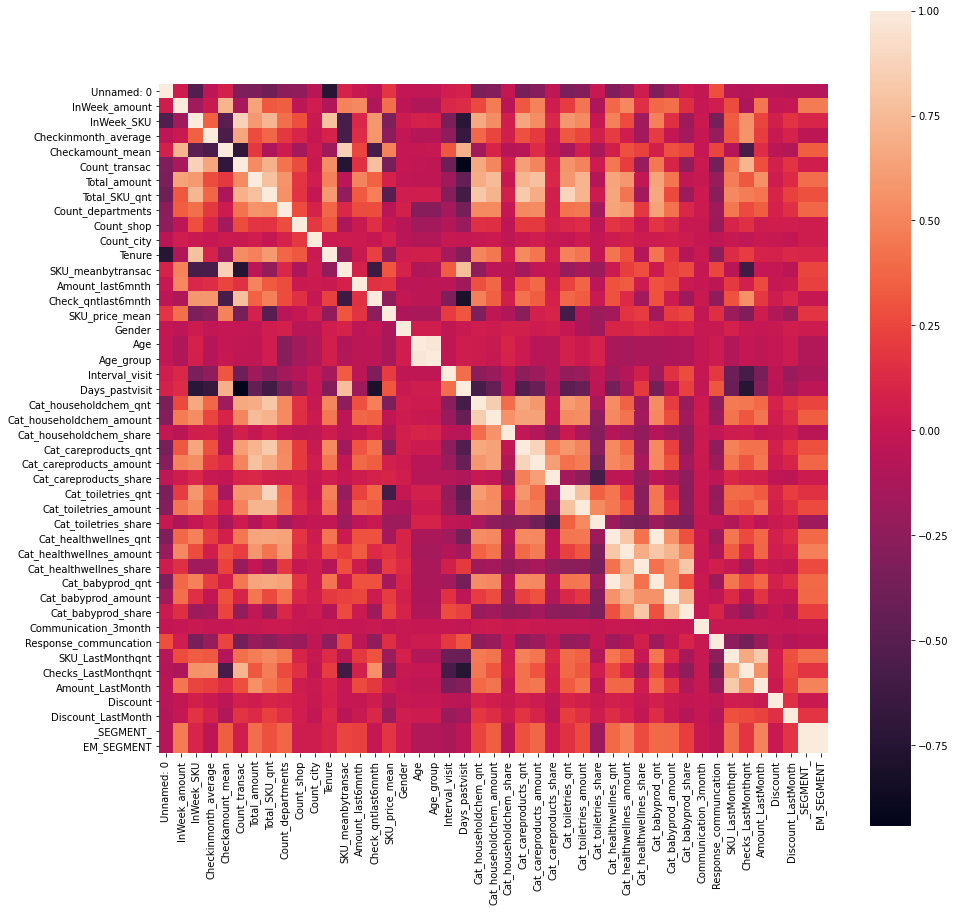

In [30]:
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, square=True)

Отдельное внимание уделим колонкам которые хорошо (>0.9) коррелируют друг с другом.

От них можно избавиться без критичной потери информации.

Index(['Count_transac', 'Age', 'Age_group', 'Days_pastvisit',
       'Cat_healthwellnes_qnt', 'Cat_babyprod_qnt', '_SEGMENT_', 'EM_SEGMENT'],
      dtype='object')


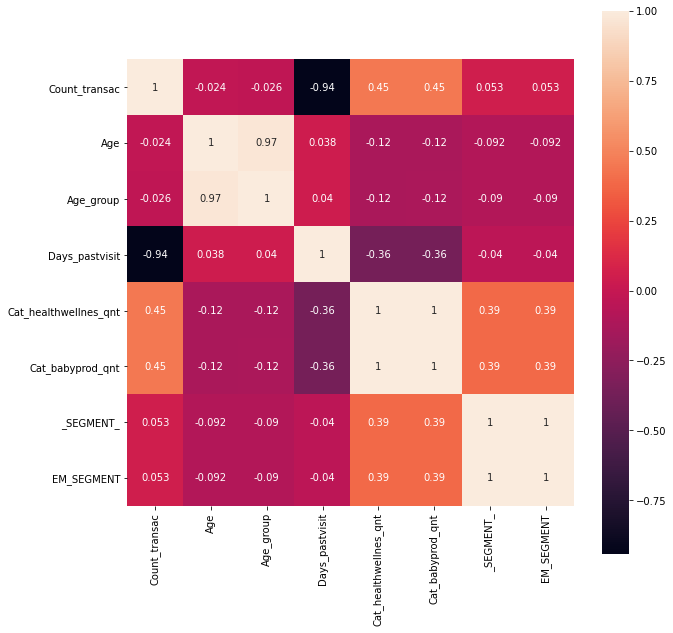

In [31]:
features = df.columns[(corrmat.abs()>0.9).sum()>1]
corrmat_f = df[features].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat_f, square=True, annot=True)

print(features)

Удаляем сильно скоррелированные колонки

In [32]:
df.drop(columns=[
    'EM_SEGMENT',
    'Cat_babyprod_qnt',
], inplace=True)

df.shape

(27267, 43)

### Кластеризация

Кластеризация в многомерном пространстве представляет собой чрезвычайно сложную задачу (Curse of dimensionality).

Попытаемся понизить размерность задачи.

В данных очевидно есть линейно зависимые колонки.

Например, из 'Total_amount' и 'Count_transac'  можно получить 'Checkamount_mean', делая использование последней не очень полезным.

Для того чтобы избавиться от подобных неинформативных колонок, попробуем преобразовать строки таблицы в эмбединги меньшей размерности.

Для создания эмбедингов воспользуемся автоэнкодером.

Напишем простой автоэнкодер который попытается снизить размерность с 43 до 28.

#### AutoEncoder

In [33]:
import torch
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self, shape):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Linear(shape, shape-5),
            nn.ReLU(),
            nn.Linear(shape-5, shape-10),
            nn.ReLU(),
            nn.Linear(shape-10, shape-15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(shape-15, shape-10),
            nn.ReLU(),
            nn.Linear(shape-10, shape-5),
            nn.ReLU(),
            nn.Linear(shape-5, shape),

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate, 
                                weight_decay=1e-5) # <--

    outputs = []
    for epoch in range(num_epochs):
        permutation = torch.randperm(train_data.size()[0])
        for i in range(0,train_data.size()[0], batch_size):
        # for i in range(train_data.shape[0]):
            indices = permutation[i:i+batch_size]
            batch = train_data[indices]

            recon = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            outputs.append(loss)
        if epoch % 10 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    return outputs

In [34]:
train_data = df[:]
train_data = train_data.values
train_data = torch.tensor(train_data).to(torch.float)

model = Autoencoder(train_data.size()[1])

In [ ]:
max_epochs = 200
outputs = train(model, num_epochs=max_epochs, batch_size=100)

fig, ax = plt.subplots()
ax.plot(np.log10(outputs))
ax.set_title("Autoencoder's loss")

/home/drev/.virtualenvs/py3/lib/python3.9/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


Epoch:1, Loss:0.3629
Epoch:11, Loss:0.0660
Epoch:21, Loss:0.0443
Epoch:31, Loss:0.0524
Epoch:41, Loss:0.0443
Epoch:51, Loss:0.0391
Epoch:61, Loss:0.0373
Epoch:71, Loss:0.0358
Epoch:81, Loss:0.0258
Epoch:91, Loss:0.0227
Epoch:101, Loss:0.0232
Epoch:111, Loss:0.0243
Epoch:121, Loss:0.0200
Epoch:131, Loss:0.0240


Проверяем на нескольких примерах, что autoencoder выдает что-то вменяемое

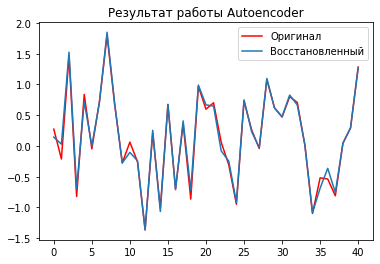

In [178]:
i = 7

fig, ax = plt.subplots()
ax.plot(df.values[i], c='r', label='Оригинал')
ax.plot(model(torch.tensor(df.loc[i].values).to(torch.float)).detach().numpy(), label='Восстановленный')
ax.set_title('Результат работы Autoencoder')
plt.legend()

In [22]:
data_encoded = model.encoder(torch.tensor(df.values).to(torch.float))
data_encoded = data_encoded.detach().numpy()
data_encoded.shape

(27267, 26)

#### t-SNE


Размерность понизили, но 28 всё еще много чтоб напрямую кластеризовать.

Эффективнее будет воспользоваться алгоритмом t-SNE, который с помощью нелинейного преобразования проецирует данные на пространство меньшей размерности, пытаясь сохранить расстояние между ними.

In [23]:
%%time
from sklearn.manifold import TSNE
X = data_encoded
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(data_encoded)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27267 samples in 0.127s...
[t-SNE] Computed neighbors for 27267 samples in 113.708s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27267
[t-SNE] Computed conditional probabilities for sample 2000 / 27267
[t-SNE] Computed conditional probabilities for sample 3000 / 27267
[t-SNE] Computed conditional probabilities for sample 4000 / 27267
[t-SNE] Computed conditional probabilities for sample 5000 / 27267
[t-SNE] Computed conditional probabilities for sample 6000 / 27267
[t-SNE] Computed conditional probabilities for sample 7000 / 27267
[t-SNE] Computed conditional probabilities for sample 8000 / 27267
[t-SNE] Computed conditional probabilities for sample 9000 / 27267
[t-SNE] Computed conditional probabilities for sample 10000 / 27267
[t-SNE] Computed conditional probabilities for sample 11000 / 27267
[t-SNE] Computed conditional probabilities for sample 12000 / 27267
[t-SNE] Computed conditional probabilities for s

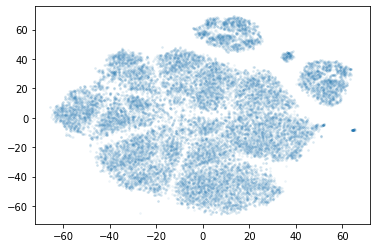

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=3, alpha=0.05)

Визуально похоже на то, что какие-то кластеры в данных нашлись.

Пробуем выделить их алгоритмом кластеризации DBSCAN.

#### **DBSCAN**

DBSCAN хорош тем, что не требует предварительного задания числа кластеров и умеет находить кластеры со сложной топологией

In [135]:
clustering = DBSCAN(eps=5, min_samples=200).fit(X_embedded)
labels = clustering.labels_
del clustering
# del X
n_clusters_ = len(set(labels))
print(n_clusters_)
print(set(labels))

5
{0, 1, 2, 3, -1}


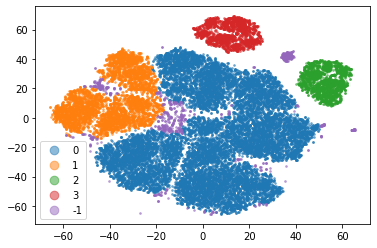

In [136]:
fig, ax = plt.subplots()
for label in set(labels):
    mask = labels==label
    ax.scatter(X_embedded[mask][:,0], X_embedded[mask][:,1], s=3, alpha=0.5, label=label)

plt.legend(markerscale=5)
plt.show()

Отлично, получили кластеры

В зависимости от задачи - можно делить данные на более мелкие кластеры, но пока пройдемся широкими мазками

4 кластера вполне достаточно.

### Анализ получившихся кластеров

Попытаемся понять какие парамеры стали ключевыми при кластеризации, и как кластеры можно трактовать

In [137]:
sub_df_raw = df_raw.copy()
sub_df = df.copy()

Добавляем метки кластеров к нормализованным и оригинальным данным.

Избавляемся строк, которые не попали ни в один из кластеров.

In [138]:
sub_df['labels'] = labels
sub_df_raw['labels'] = labels

sub_df = sub_df.drop(sub_df[sub_df['labels'] == -1].index)
sub_df_raw = sub_df_raw.drop(sub_df_raw[sub_df_raw['labels'] == -1].index)

sub_df_raw['labels'].value_counts()

0    17535
1     5090
2     1919
3     1848
Name: labels, dtype: int64

Ищем колонки в которых средние значения отличаются для разных кластеров

In [176]:
std_of_mean = sub_df.groupby(by='labels').mean().std().sort_values(ascending=False)
columns = std_of_mean[:15].index

std_of_mean.head(15)

Count_city               1.865861
Discount_LastMonth       1.852682
Checkinmonth_average     1.039539
Checks_LastMonthqnt      0.842250
Count_transac            0.793229
Days_pastvisit           0.785362
SKU_LastMonthqnt         0.690931
Check_qntlast6mnth       0.665362
SKU_meanbytransac        0.616406
Checkamount_mean         0.613821
Total_SKU_qnt            0.608668
Cat_householdchem_qnt    0.565770
Cat_toiletries_qnt       0.555912
InWeek_SKU               0.539813
Amount_LastMonth         0.536147
dtype: float64

Cмотрим, на отличия в распределении данных для различных кластеров

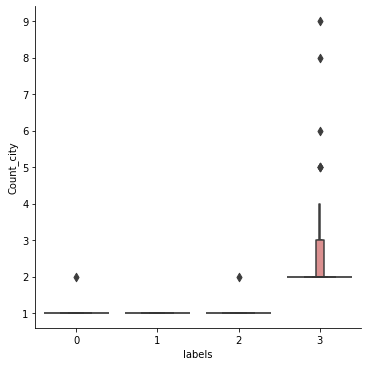

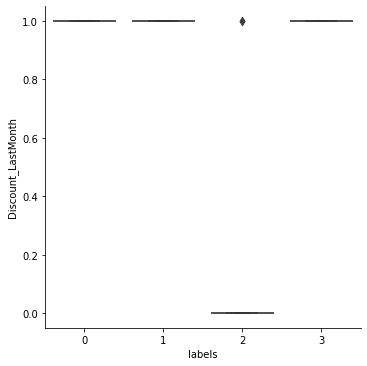

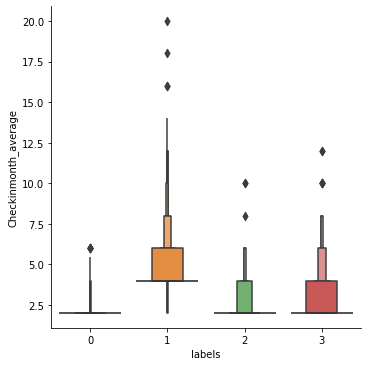

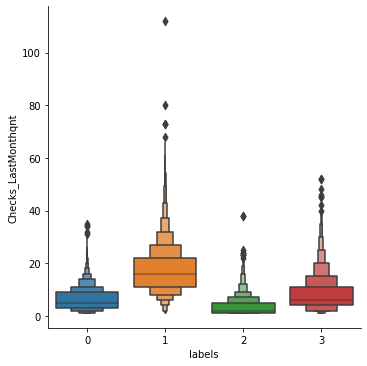

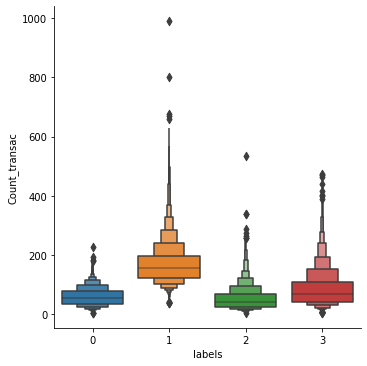

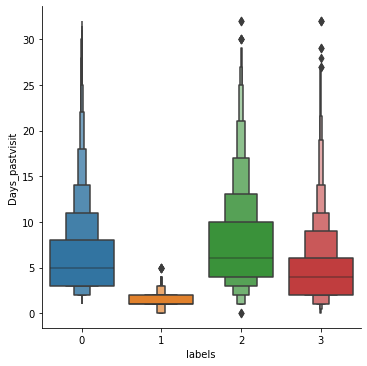

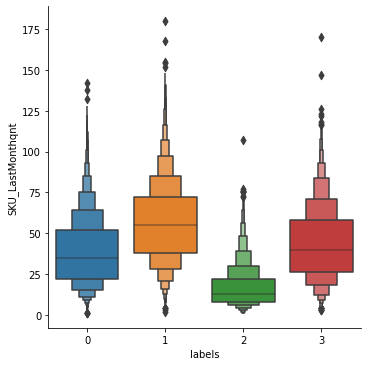

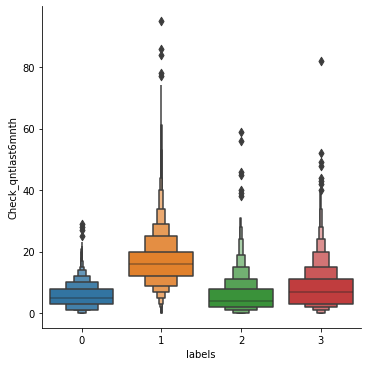

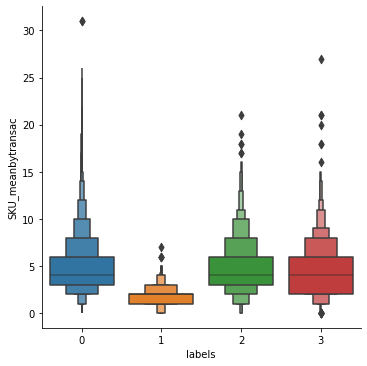

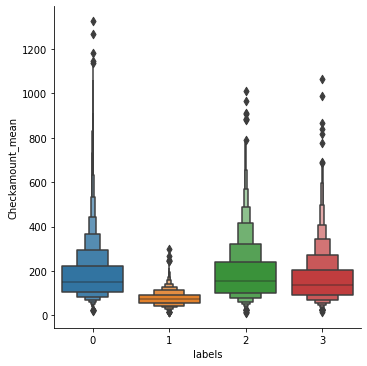

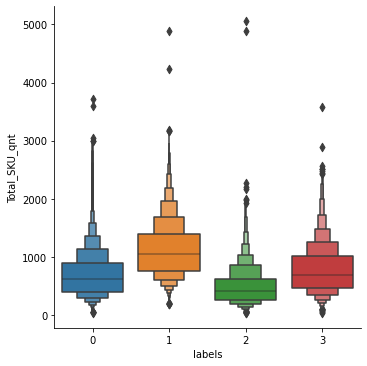

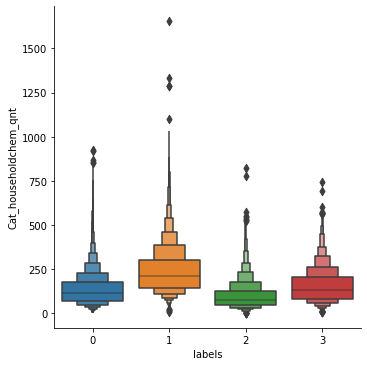

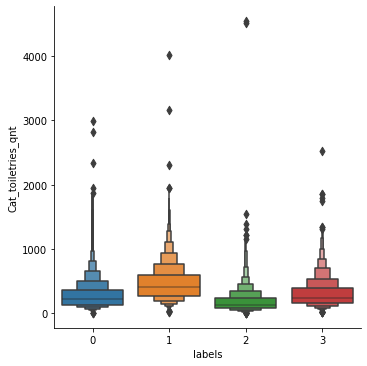

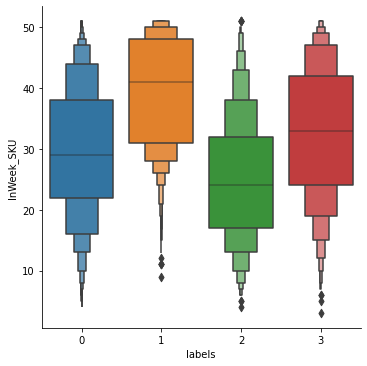

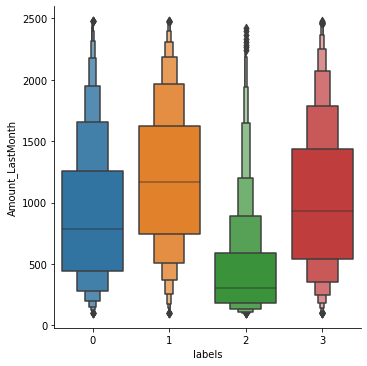

In [175]:
for col in columns:
    g = sns.catplot(x='labels', y=col, data=sub_df_raw, kind="boxen")
# plt.show()

Пытаясь угадать по их названию колонок, что за информация в них лежит, можно как-то интерпретировать полученный результат:

 - Например, в кластере #2 - малое количество чеков за прошлый месяц (Checks_LastMonthqnt), большое число дней со времени прошлого визита('Days_pastvisit'), но типичная сумма чека ('Checkamount_mean') не сильно отличается от средней. Можно предположить, что в этот кластер попали клиенты, которые в последнее время стали меньше пользоваться услугами компании.
 - В кластере #1 большое число чеков за последнее время ('Check_qntlast6mnth'), малое время с момента последнего визита ('Days_pastvisit'). Этот кластер похож на активных постоянных клиентов.
 - Кластеры #0 и #3 очень похожи друг на друга по большинству параметров, кроме параметра 'Count_city'. Возможно это паразитный эффект и кластеры не стоило делить между собой. Можно было бы исключить колонку "Count_city" из анализа, но для этого нужно понимать какую информацию она в себе несет.

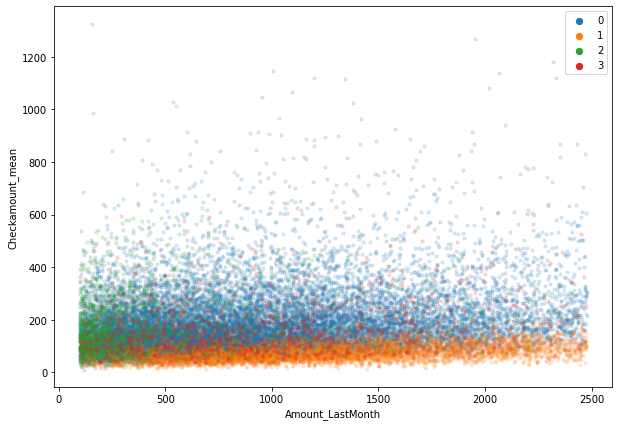

In [179]:
fig, ax = plt.subplots(figsize=(10,7))
col1 = 'Amount_LastMonth'
col2 = 'Checkamount_mean'
for label in sub_df_raw['labels'].unique():
    mask = sub_df_raw['labels']==label
    ax.scatter(sub_df_raw[mask][col1], sub_df_raw[mask][col2], s=10, alpha=0.15,label=label)

ax.set_xlabel(col1)
ax.set_ylabel(col2)
leg = plt.legend(markerscale=2)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

Можно строить подобные картинки.

Здесь, например, наглядно видно, что оранжевый кластер №1 соответствует малым значениям в колонке "Checkamount_mean" , а зеленый кластер №2 - малым значениям в колонке "Amount_LastMonth". Красный кластер №3 не имеет ярко выраженной структуры.

### Fin

Сделали модельку/пайплайн который может кластеризовать сложные многомерные данные о клиентах.

Полученные кластеры можно интерпретировать и отнести к различным сегментам клиентов.

Модель можно гибко подстраивать под различные задачи.